### Access to the files through drive or github

<a href='https://drive.google.com/drive/folders/1jEF_DppUP2QuFfs7neMqDiZ9GAGapCj0?usp=drive_link'>Drive Link</a> <br>
<a href='https://github.com/rajasaikatukuri/projectpython'>Github Link</a>

### My Resume

<a href='https://drive.google.com/file/d/1A6WNjLcu0Kjo1V3GOfnvbTGT4yShC42y/view?usp=drive_link'>Resume</a>

### My Video

<a href='https://drive.google.com/file/d/1y-vOXtXUcvllfBJy23-3gQ7CPCxrp-G5/view?usp=drive_link'>Video Link</a>

### Links for Dagshub, Dockerhub, Deployed model, Streamlit app

<a href='https://dagshub.com/rajasaikatukuri/pythonproject/experiments'>Dagshub</a> <br>
<a href='https://hub.docker.com/r/rajasaik/fastapi-breast-cancer-app'>Dockerhub</a> <br>
<a href='https://dashboard.render.com/web/srv-ctivlb3qf0us73989du0'>Deployed Model</a> <br> 
<a href='https://rajasaikatukuri-projectpython-app-ba2ctr.streamlit.app/'>Streamlit</a> 

**Importing the Necessary Libararies**

In [1]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, OneHotEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer
from xgboost import XGBClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
import mlflow
import mlflow.sklearn
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin


**loading the dataset**

In [2]:
file_path = '/Users/rajasaikatukuri/Downloads/projectpython/breast-cancer.csv'
data = pd.read_csv(file_path)
data

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


**Normalizing the Data**

In [3]:
conn = sqlite3.connect("breast_cancer_normalized.db")
cursor = conn.cursor()

cursor.execute("""
CREATE TABLE IF NOT EXISTS Patients (
    PatientID INTEGER PRIMARY KEY,
    Diagnosis TEXT
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS Measurements (
    PatientID INTEGER,
    MeasurementType TEXT,
    Value REAL,
    FOREIGN KEY (PatientID) REFERENCES Patients(PatientID)
);
""")

patients_data = data[['id', 'diagnosis']].rename(columns={'id': 'PatientID', 'diagnosis': 'Diagnosis'})
patients_data.to_sql('Patients', conn, if_exists='replace', index=False)

measurements = data.drop(columns=['id', 'diagnosis'])
measurements['PatientID'] = data['id']
measurements_long = measurements.melt(
    id_vars=['PatientID'],
    var_name="MeasurementType",
    value_name="Value"
)
measurements_long.to_sql('Measurements', conn, if_exists='replace', index=False)

print("Patients Table:")
print(pd.read_sql_query("SELECT * FROM Patients LIMIT 5;", conn))
print("\nMeasurements Table:")
print(pd.read_sql_query("SELECT * FROM Measurements LIMIT 5;", conn))

print("\nDistinct Measurement Types:")
print(pd.read_sql_query("SELECT DISTINCT MeasurementType FROM Measurements;", conn))

print("\nTotal Rows in Measurements Table:")
print(pd.read_sql_query("SELECT COUNT(*) FROM Measurements;", conn))

distribution_query = """
SELECT MeasurementType, COUNT(*) AS Count
FROM Measurements
GROUP BY MeasurementType
ORDER BY MeasurementType;
"""
column_distribution = pd.read_sql_query(distribution_query, conn)
print("\nData Distribution per Column:")
print(column_distribution)

query = """
SELECT Patients.PatientID, Patients.Diagnosis, Measurements.MeasurementType, Measurements.Value
FROM Patients
JOIN Measurements ON Patients.PatientID = Measurements.PatientID
"""
data_normalized = pd.read_sql_query(query, conn)

data_pivoted = data_normalized.pivot_table(index='PatientID', columns='MeasurementType', values='Value', aggfunc='mean')
data_pivoted['Diagnosis'] = data_normalized.groupby('PatientID')['Diagnosis'].first()

data_pivoted['Diagnosis'] = data_pivoted['Diagnosis'].map({'M': 1, 'B': 0})

missing_values = data_pivoted.isnull().sum()
print("\nMissing Values per Column:")
print(missing_values)

data_pivoted.fillna(data_pivoted.mean(), inplace=True)
print("\nMissing Values after Imputation:")
print(data_pivoted.isnull().sum())

Patients Table:
   PatientID Diagnosis
0     842302         M
1     842517         M
2   84300903         M
3   84348301         M
4   84358402         M

Measurements Table:
   PatientID MeasurementType  Value
0     842302     radius_mean  17.99
1     842517     radius_mean  20.57
2   84300903     radius_mean  19.69
3   84348301     radius_mean  11.42
4   84358402     radius_mean  20.29

Distinct Measurement Types:
            MeasurementType
0               radius_mean
1              texture_mean
2            perimeter_mean
3                 area_mean
4           smoothness_mean
5          compactness_mean
6            concavity_mean
7       concave points_mean
8             symmetry_mean
9    fractal_dimension_mean
10                radius_se
11               texture_se
12             perimeter_se
13                  area_se
14            smoothness_se
15           compactness_se
16             concavity_se
17        concave points_se
18              symmetry_se
19     fractal_dimen

**Changing of columns to correct format**

In [4]:
data_pivoted.rename(columns={
    'concave points_mean': 'concave_points_mean',
    'concave points_se': 'concave_points_se',
    'concave points_worst': 'concave_points_worst'
}, inplace=True)


**Insights about column names**

In [5]:
columns = data_pivoted.columns
print(columns)


Index(['area_mean', 'area_se', 'area_worst', 'compactness_mean',
       'compactness_se', 'compactness_worst', 'concave_points_mean',
       'concave_points_se', 'concave_points_worst', 'concavity_mean',
       'concavity_se', 'concavity_worst', 'fractal_dimension_mean',
       'fractal_dimension_se', 'fractal_dimension_worst', 'perimeter_mean',
       'perimeter_se', 'perimeter_worst', 'radius_mean', 'radius_se',
       'radius_worst', 'smoothness_mean', 'smoothness_se', 'smoothness_worst',
       'symmetry_mean', 'symmetry_se', 'symmetry_worst', 'texture_mean',
       'texture_se', 'texture_worst', 'Diagnosis'],
      dtype='object', name='MeasurementType')


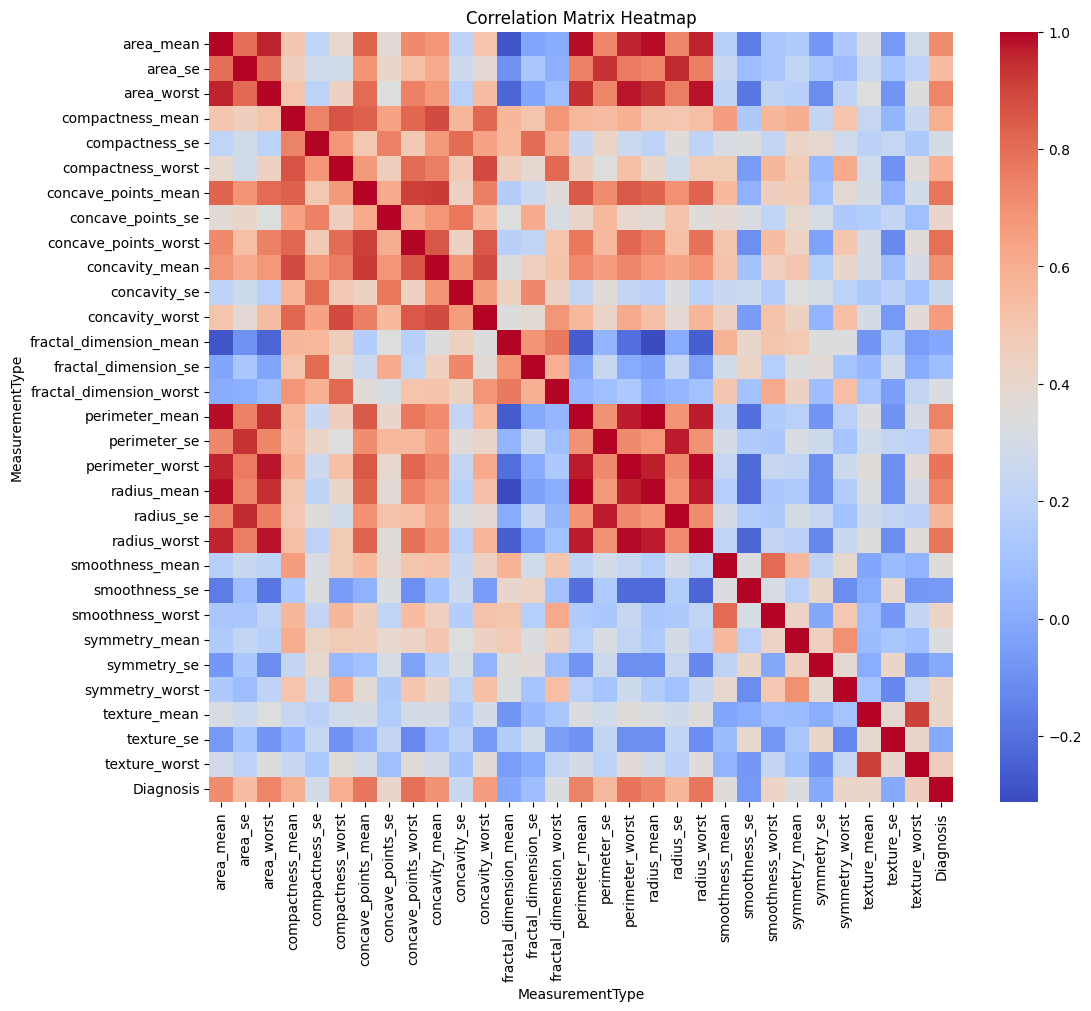

In [6]:

plt.figure(figsize=(12, 10))
correlation_matrix = data_pivoted.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Heatmap")
heatmap_file = "/Users/rajasaikatukuri/Downloads/projectpython/correlation_matrix_corrected.png"
plt.savefig(heatmap_file)
plt.show()


The correlation matrix reveals strong correlations among features like radius_mean, area_mean, and perimeter_mean, indicating redundancy. Features like concave_points_mean are highly predictive of Diagnosis, while others (e.g., fractal_dimension_mean) have weak correlations. Address multicollinearity via feature selection or PCA and prioritize features strongly linked to Diagnosis for efficient modeling.

/var/folders/01/g8lfxqld0f55zhyqdjg50qwc0000gn/T/ipykernel_28447/2943075828.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0, 0], x=data_pivoted['Diagnosis'], palette="coolwarm")
/var/folders/01/g8lfxqld0f55zhyqdjg50qwc0000gn/T/ipykernel_28447/2943075828.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0, 1], x=data_pivoted['Diagnosis'], y=data_pivoted['area_mean'], palette="coolwarm")
/var/folders/01/g8lfxqld0f55zhyqdjg50qwc0000gn/T/ipykernel_28447/2943075828.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax

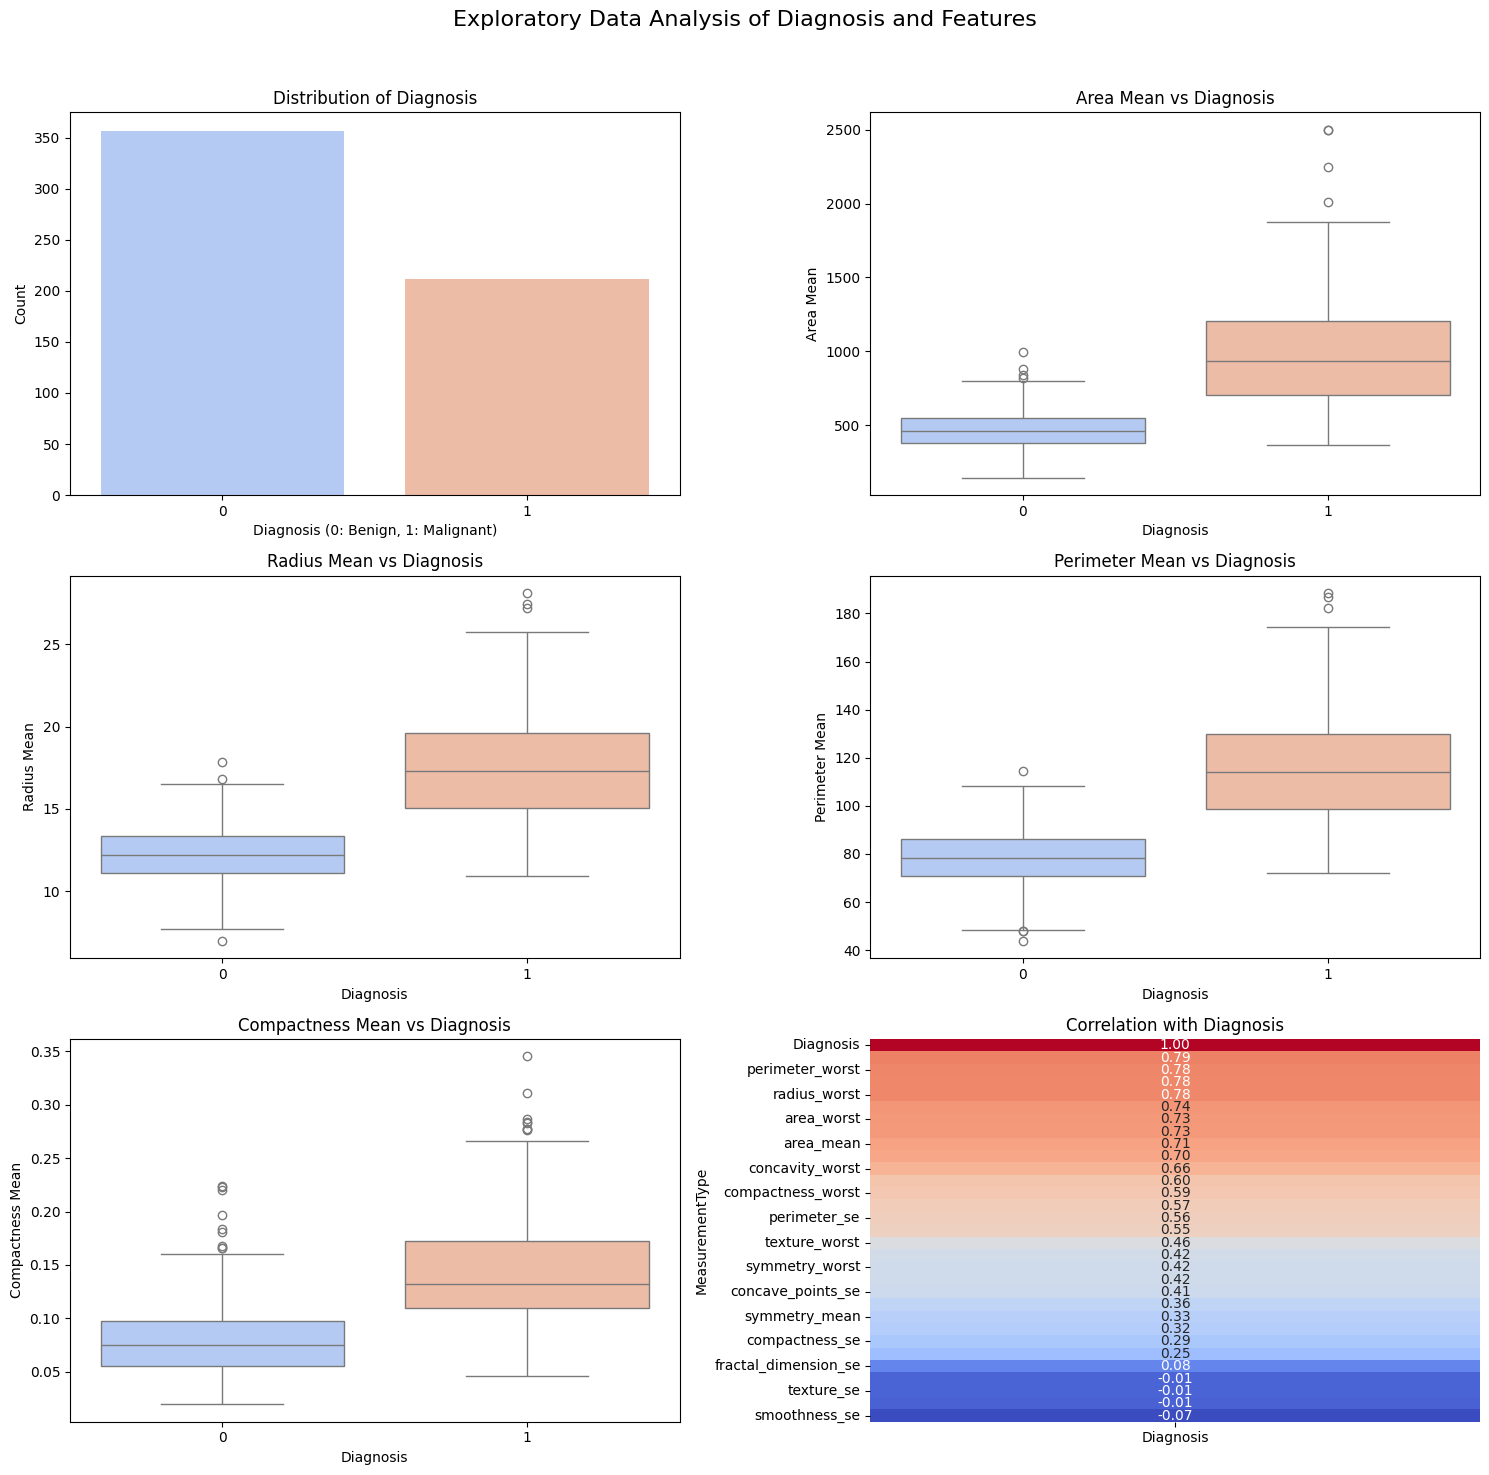

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle("Exploratory Data Analysis of Diagnosis and Features", fontsize=16)

sns.countplot(ax=axes[0, 0], x=data_pivoted['Diagnosis'], palette="coolwarm")
axes[0, 0].set_title("Distribution of Diagnosis")
axes[0, 0].set_xlabel("Diagnosis (0: Benign, 1: Malignant)")
axes[0, 0].set_ylabel("Count")

sns.boxplot(ax=axes[0, 1], x=data_pivoted['Diagnosis'], y=data_pivoted['area_mean'], palette="coolwarm")
axes[0, 1].set_title("Area Mean vs Diagnosis")
axes[0, 1].set_xlabel("Diagnosis")
axes[0, 1].set_ylabel("Area Mean")

sns.boxplot(ax=axes[1, 0], x=data_pivoted['Diagnosis'], y=data_pivoted['radius_mean'], palette="coolwarm")
axes[1, 0].set_title("Radius Mean vs Diagnosis")
axes[1, 0].set_xlabel("Diagnosis")
axes[1, 0].set_ylabel("Radius Mean")

sns.boxplot(ax=axes[1, 1], x=data_pivoted['Diagnosis'], y=data_pivoted['perimeter_mean'], palette="coolwarm")
axes[1, 1].set_title("Perimeter Mean vs Diagnosis")
axes[1, 1].set_xlabel("Diagnosis")
axes[1, 1].set_ylabel("Perimeter Mean")

sns.boxplot(ax=axes[2, 0], x=data_pivoted['Diagnosis'], y=data_pivoted['compactness_mean'], palette="coolwarm")
axes[2, 0].set_title("Compactness Mean vs Diagnosis")
axes[2, 0].set_xlabel("Diagnosis")
axes[2, 0].set_ylabel("Compactness Mean")

correlation_with_target = data_pivoted.corr()['Diagnosis'].sort_values(ascending=False)
sns.heatmap(correlation_with_target.to_frame(), ax=axes[2, 1], annot=True, cmap="coolwarm", cbar=False, fmt='.2f')
axes[2, 1].set_title("Correlation with Diagnosis")

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the main title
plt.show()


**Splitting the dataset into training and testing**

In [8]:

X = data_pivoted.drop(columns=['Diagnosis'])
y = data_pivoted['Diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [9]:
X_train

MeasurementType,area_mean,area_se,area_worst,compactness_mean,compactness_se,compactness_worst,concave_points_mean,concave_points_se,concave_points_worst,concavity_mean,...,radius_worst,smoothness_mean,smoothness_se,smoothness_worst,symmetry_mean,symmetry_se,symmetry_worst,texture_mean,texture_se,texture_worst
PatientID,,,,,,,,,,,,,,,,,,,,,
90291,664.7,33.01,758.2,0.06636,0.01742,0.15810,0.05271,0.015760,0.13590,0.08390,...,15.79,0.08682,0.008312,0.1312,0.1627,0.01740,0.2477,23.29,1.627,31.71
871642,349.6,21.98,408.3,0.04302,0.01017,0.06791,0.00000,0.000000,0.00000,0.00000,...,11.54,0.08792,0.008713,0.1076,0.1928,0.03265,0.2710,15.15,1.925,19.20
923465,361.6,33.00,505.6,0.06602,0.01870,0.16330,0.00816,0.005917,0.03264,0.01548,...,13.03,0.08192,0.008263,0.1204,0.1976,0.02466,0.3059,24.21,1.918,31.45
84458202,577.9,50.96,897.0,0.16450,0.03029,0.36820,0.05985,0.014480,0.15560,0.09366,...,17.06,0.11890,0.008805,0.1654,0.2196,0.01486,0.3196,20.83,1.377,28.14
851509,1404.0,93.99,2615.0,0.10220,0.01259,0.26000,0.08632,0.010380,0.20090,0.10970,...,29.17,0.09428,0.004728,0.1401,0.1769,0.01083,0.2822,23.04,1.127,35.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86211,451.1,24.44,495.2,0.07057,0.01179,0.09358,0.02941,0.015190,0.05882,0.02490,...,12.83,0.10450,0.005433,0.1140,0.1900,0.02220,0.2227,17.84,1.511,20.92
924934,321.4,14.46,357.6,0.07658,0.02736,0.17100,0.02738,0.017210,0.09127,0.05999,...,10.84,0.09030,0.012050,0.1384,0.1593,0.01843,0.2226,27.61,2.239,34.91
8910499,561.0,26.76,661.5,0.08259,0.02406,0.17300,0.02142,0.009919,0.06189,0.04072,...,14.80,0.07956,0.005436,0.1005,0.1635,0.02030,0.2446,21.84,1.916,30.04


In [10]:

preprocessor = StandardScaler()


**Initializing the dagshub**

In [11]:

import dagshub
dagshub.init(repo_owner='rajasaikatukuri', repo_name='pythonproject', mlflow=True)

Accessing as rajasaikatukuri

Initialized MLflow to track repo "rajasaikatukuri/pythonproject"

Repository rajasaikatukuri/pythonproject initialized!

**experiment 1**

In [12]:

mlflow.set_tracking_uri("https://dagshub.com/rajasaikatukuri/pythonproject.mlflow")
mlflow.set_experiment("Breast Cancer Logistic Regression Experiment 1")

<Experiment: artifact_location='mlflow-artifacts:/21b542c67afe4dfda003fecd859e520d', creation_time=1734651988119, experiment_id='5', last_update_time=1734651988119, lifecycle_stage='active', name='Breast Cancer Logistic Regression Experiment 1', tags={}>

In [13]:

with mlflow.start_run(run_name="Experiment 1: Preprocessing + Logistic Regression"):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('minmax', MinMaxScaler()),
        ('log', FunctionTransformer(np.log1p, validate=True)),
        ('clf', LogisticRegression(max_iter=1000, random_state=42))
    ])
    param_grid = {'clf__C': [0.1, 1, 10]}
    grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1', return_train_score=True)
    grid_search.fit(X_train, y_train)

    best_pipeline = grid_search.best_estimator_
    
    # Cross-validation results
    cv_results = cross_val_score(best_pipeline, X_train, y_train, cv=10, scoring='f1')
    
    # Evaluate F1 score on test data
    y_pred = best_pipeline.predict(X_test)
    test_f1 = f1_score(y_test, y_pred)

    # Log metrics and parameters
    mlflow.log_metric("f1_score_mean", cv_results.mean())
    mlflow.log_metric("f1_score_std", cv_results.std())
    mlflow.log_metric("test_f1_score", test_f1)
    mlflow.log_params(grid_search.best_params_)

    input_example = pd.DataFrame(X_test.iloc[0:1])
    mlflow.sklearn.log_model(best_pipeline, "logistic_regression_pipeline", input_example=input_example)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


🏃 View run Experiment 1: Preprocessing + Logistic Regression at: https://dagshub.com/rajasaikatukuri/pythonproject.mlflow/#/experiments/5/runs/cffe60031abc4689b36ebb8dd946ad97
🧪 View experiment at: https://dagshub.com/rajasaikatukuri/pythonproject.mlflow/#/experiments/5


In [14]:
# import joblib
# joblib.dump(best_pipeline, "/Users/rajasaikatukuri/Downloads/pythonproject/logistic_regression_pipeline.joblib")
# print("Model saved as logistic_regression_pipeline.joblib")


**Experiment 2**

In [15]:

mlflow.set_tracking_uri("https://dagshub.com/rajasaikatukuri/pythonproject.mlflow")
mlflow.set_experiment("Breast Cancer Multi-Classifier Experiment 2")

<Experiment: artifact_location='mlflow-artifacts:/4c9d6bf916b04a7f9ae04cd4e269a48c', creation_time=1734652222649, experiment_id='6', last_update_time=1734652222649, lifecycle_stage='active', name='Breast Cancer Multi-Classifier Experiment 2', tags={}>

In [16]:

classifiers = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RidgeClassifier': RidgeClassifier(random_state=42),
    'RandomForestClassifier': RandomForestClassifier(random_state=42)
}

for name, clf in classifiers.items():
    with mlflow.start_run(run_name=name):
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', clf)
        ])

        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='f1')
        mean_cv_f1 = np.mean(cv_scores)
        std_cv_f1 = np.std(cv_scores)
        mlflow.log_metric("f1_score_mean", mean_cv_f1)
        mlflow.log_metric("f1_score_std", std_cv_f1)

        pipeline.fit(X_train, y_train)

        y_pred = pipeline.predict(X_test)
        test_f1 = f1_score(y_test, y_pred)
        mlflow.log_metric("test_f1_score", test_f1)

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        mlflow.log_metric("True_Positives", tp)
        mlflow.log_metric("True_Negatives", tn)
        mlflow.log_metric("False_Positives", fp)
        mlflow.log_metric("False_Negatives", fn)

        mlflow.sklearn.log_model(
            sk_model=pipeline,
            artifact_path="model",
            input_example=X_test.iloc[0].to_dict(),
            registered_model_name=f"{name.replace(' ', '_')}_Pipeline"
        )

class SklearnXGBWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, **kwargs):
        self.model = XGBClassifier(**kwargs)

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

with mlflow.start_run(run_name="XGB Classifier"):
    xgb_wrapper = SklearnXGBWrapper(random_state=42, eval_metric='logloss')

    cv_scores = cross_val_score(xgb_wrapper, X_train, y_train, cv=3, scoring='f1')
    mean_cv_f1 = np.mean(cv_scores)
    std_cv_f1 = np.std(cv_scores)
    mlflow.log_metric("f1_score_mean", mean_cv_f1)
    mlflow.log_metric("f1_score_std", std_cv_f1)

    xgb_wrapper.fit(X_train, y_train)

    y_pred = xgb_wrapper.predict(X_test)
    test_f1 = f1_score(y_test, y_pred)
    mlflow.log_metric("test_f1_score", test_f1)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    mlflow.log_metric("True_Positives", tp)
    mlflow.log_metric("True_Negatives", tn)
    mlflow.log_metric("False_Positives", fp)
    mlflow.log_metric("False_Negatives", fn)

    mlflow.sklearn.log_model(
        sk_model=xgb_wrapper,
        artifact_path="xgb_model",
        input_example=X_test.iloc[0].to_dict(),
        registered_model_name="XGB_Classifier"
    )

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LogisticRegression_Pipeline' already exists. Creating a new version of this model...
2024/12/20 20:57:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model 

🏃 View run LogisticRegression at: https://dagshub.com/rajasaikatukuri/pythonproject.mlflow/#/experiments/6/runs/9c47bc46708c4dbb8304791b846780b3
🧪 View experiment at: https://dagshub.com/rajasaikatukuri/pythonproject.mlflow/#/experiments/6


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'RidgeClassifier_Pipeline' already exists. Creating a new version of this model...
2024/12/20 20:57:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model ver

🏃 View run RidgeClassifier at: https://dagshub.com/rajasaikatukuri/pythonproject.mlflow/#/experiments/6/runs/1d35afd60c8d489a94d8b63f496c700c
🧪 View experiment at: https://dagshub.com/rajasaikatukuri/pythonproject.mlflow/#/experiments/6


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'RandomForestClassifier_Pipeline' already exists. Creating a new version of this model...
2024/12/20 20:57:51 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for mo

🏃 View run RandomForestClassifier at: https://dagshub.com/rajasaikatukuri/pythonproject.mlflow/#/experiments/6/runs/fc0cb6c4cd41449a811ecbab3bf86bcf
🧪 View experiment at: https://dagshub.com/rajasaikatukuri/pythonproject.mlflow/#/experiments/6


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'XGB_Classifier' already exists. Creating a new version of this model...
2024/12/20 20:58:13 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to fi

🏃 View run XGB Classifier at: https://dagshub.com/rajasaikatukuri/pythonproject.mlflow/#/experiments/6/runs/b67b6ffd087b495897c49ecd414f2421
🧪 View experiment at: https://dagshub.com/rajasaikatukuri/pythonproject.mlflow/#/experiments/6


**Experiment 3**

In [17]:

mlflow.set_tracking_uri("https://dagshub.com/rajasaikatukuri/pythonproject.mlflow")
mlflow.set_experiment("Breast Cancer Multi-Classifier Experiment 3")

<Experiment: artifact_location='mlflow-artifacts:/df0f4247039f4de4ad70d1332290688b', creation_time=1734653003582, experiment_id='7', last_update_time=1734653003582, lifecycle_stage='active', name='Breast Cancer Multi-Classifier Experiment 3', tags={}>

In [18]:
classifiers = {
    'LogisticRegression': LogisticRegression(max_iter=5000, random_state=42),
    'RidgeClassifier': RidgeClassifier(random_state=42),
    'RandomForestClassifier': RandomForestClassifier(random_state=42)
}

preprocessor = Pipeline([
    ('scaler', StandardScaler())
])

X_train['area_to_radius_mean'] = X_train['area_mean'] / X_train['radius_mean']
X_test['area_to_radius_mean'] = X_test['area_mean'] / X_test['radius_mean']

X_train['radius_mean_squared'] = X_train['radius_mean'] ** 2
X_test['radius_mean_squared'] = X_test['radius_mean'] ** 2

X_train['log_area_mean'] = np.log1p(X_train['area_mean'])
X_test['log_area_mean'] = np.log1p(X_test['area_mean'])



In [19]:
print(X_train.columns)

Index(['area_mean', 'area_se', 'area_worst', 'compactness_mean',
       'compactness_se', 'compactness_worst', 'concave_points_mean',
       'concave_points_se', 'concave_points_worst', 'concavity_mean',
       'concavity_se', 'concavity_worst', 'fractal_dimension_mean',
       'fractal_dimension_se', 'fractal_dimension_worst', 'perimeter_mean',
       'perimeter_se', 'perimeter_worst', 'radius_mean', 'radius_se',
       'radius_worst', 'smoothness_mean', 'smoothness_se', 'smoothness_worst',
       'symmetry_mean', 'symmetry_se', 'symmetry_worst', 'texture_mean',
       'texture_se', 'texture_worst', 'area_to_radius_mean',
       'radius_mean_squared', 'log_area_mean'],
      dtype='object', name='MeasurementType')


In [20]:
X_train = X_train.astype(float)
X_test = X_test.astype(float)

for name, clf in classifiers.items():
    with mlflow.start_run(run_name=f"Experiment 3: {name}"):
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', clf)
        ])

        # Cross-validation
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='f1')
        mean_cv_f1 = np.mean(cv_scores)
        std_cv_f1 = np.std(cv_scores)
        mlflow.log_metric("f1_score_mean", mean_cv_f1)
        mlflow.log_metric("f1_score_std", std_cv_f1)

        # Train and evaluate
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        test_f1 = f1_score(y_test, y_pred)
        mlflow.log_metric("test_f1_score", test_f1)

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        mlflow.log_metric("True_Positives", tp)
        mlflow.log_metric("True_Negatives", tn)
        mlflow.log_metric("False_Positives", fp)
        mlflow.log_metric("False_Negatives", fn)

        input_example = pd.DataFrame(X_test.iloc[0:1])
        mlflow.sklearn.log_model(
            sk_model=pipeline,
            artifact_path="model",
            input_example=input_example.to_dict(orient='records')[0],
            registered_model_name=f"{name}_Pipeline"
        )


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'LogisticRegression_Pipeline' already exists. Creating a new version of this model...
2024/12/20 20:58:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model 

🏃 View run Experiment 3: LogisticRegression at: https://dagshub.com/rajasaikatukuri/pythonproject.mlflow/#/experiments/7/runs/1eb0987093db4d1eb6d5775ab02161f1
🧪 View experiment at: https://dagshub.com/rajasaikatukuri/pythonproject.mlflow/#/experiments/7


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'RidgeClassifier_Pipeline' already exists. Creating a new version of this model...
2024/12/20 20:58:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model ver

🏃 View run Experiment 3: RidgeClassifier at: https://dagshub.com/rajasaikatukuri/pythonproject.mlflow/#/experiments/7/runs/43fcc9437462400cb10a6c95fdfee582
🧪 View experiment at: https://dagshub.com/rajasaikatukuri/pythonproject.mlflow/#/experiments/7


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'RandomForestClassifier_Pipeline' already exists. Creating a new version of this model...
2024/12/20 20:59:19 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for mo

🏃 View run Experiment 3: RandomForestClassifier at: https://dagshub.com/rajasaikatukuri/pythonproject.mlflow/#/experiments/7/runs/d93ca10a013d49cb9da25f10791fe79c
🧪 View experiment at: https://dagshub.com/rajasaikatukuri/pythonproject.mlflow/#/experiments/7


***Experiment 4***

In [21]:

mlflow.set_tracking_uri("https://dagshub.com/rajasaikatukuri/pythonproject.mlflow")
mlflow.set_experiment("Breast Cancer Multi-Classifier Experiment 4") 

<Experiment: artifact_location='mlflow-artifacts:/a2257e8ff4b34999bbe58ce442426951', creation_time=1734640841930, experiment_id='2', last_update_time=1734640841930, lifecycle_stage='active', name='Breast Cancer Multi-Classifier Experiment 4', tags={}>

In [22]:

feature_selectors = {
    'VarianceThreshold': VarianceThreshold(threshold=0.1),
    'CorrelationThreshold': None,
    'FeatureImportance': RandomForestClassifier(random_state=42)
}

for method, selector in feature_selectors.items():
    with mlflow.start_run(run_name=f"Experiment 4: {method}"):
        if method == 'VarianceThreshold':
            selector.fit(X_train)
            X_train_reduced = selector.transform(X_train)
            X_test_reduced = selector.transform(X_test)

        elif method == 'CorrelationThreshold':
            corr_matrix = X_train.corr()
            upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
            highly_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]
            X_train_reduced = X_train.drop(columns=highly_corr_features)
            X_test_reduced = X_test.drop(columns=highly_corr_features)

        elif method == 'FeatureImportance':
            selector.fit(X_train, y_train)
            feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': selector.feature_importances_})
            selected_features = feature_importances[feature_importances['importance'] > 0.01]['feature']
            X_train_reduced = X_train[selected_features]
            X_test_reduced = X_test[selected_features]

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(max_iter=5000, random_state=42))
        ])

        cv_scores = cross_val_score(pipeline, X_train_reduced, y_train, cv=3, scoring='f1')
        mean_cv_f1 = np.mean(cv_scores)
        std_cv_f1 = np.std(cv_scores)
        mlflow.log_metric("f1_score_mean", mean_cv_f1)
        mlflow.log_metric("f1_score_std", std_cv_f1)

        pipeline.fit(X_train_reduced, y_train)
        y_pred = pipeline.predict(X_test_reduced)

        test_f1 = f1_score(y_test, y_pred)
        mlflow.log_metric("test_f1_score", test_f1)

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        mlflow.log_metric("True_Positives", tp)
        mlflow.log_metric("True_Negatives", tn)
        mlflow.log_metric("False_Positives", fp)
        mlflow.log_metric("False_Negatives", fn)

        input_example = pd.DataFrame(X_test_reduced[0:1])
        mlflow.sklearn.log_model(
            sk_model=pipeline,
            artifact_path="model",
            input_example=input_example.to_dict(orient='records')[0],
            registered_model_name=f"FeatureSelection_{method}_Pipeline"
        )

2024/12/20 20:59:29 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: MlflowException('The dictionary keys are not all strings.'). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.
2024/12/20 20:59:30 WARNING mlflow.models.model: Failed to validate serving input example {
  "inputs": {
    "0": 294.5,
    "1": 20.05,
    "2": 366.1,
    "3": 62.11,
    "4": 2.132,
    "5": 68.81,
    "6": 9.787,
    "7": 10.92,
    "8": 19.94,
    "9": 2.043,
    "10": 26.29,
    "11": 30.090936957188106,
    "12": 95.78536900000002,
    "13": 5.688668836846153
  }
}. Alternatively, you can avoid passing input example and pass model signature instead when logging the model. To ensure the input example is valid prior to serving, please try calling `mlflow.models.validate_serving_input` on the model uri and serving input example. A serving input example can be generated from model input e

🏃 View run Experiment 4: VarianceThreshold at: https://dagshub.com/rajasaikatukuri/pythonproject.mlflow/#/experiments/2/runs/6a498d1122ba471697dea8d0436e37a0
🧪 View experiment at: https://dagshub.com/rajasaikatukuri/pythonproject.mlflow/#/experiments/2


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'FeatureSelection_CorrelationThreshold_Pipeline' already exists. Creating a new version of this model...
2024/12/20 21:00:03 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300

🏃 View run Experiment 4: CorrelationThreshold at: https://dagshub.com/rajasaikatukuri/pythonproject.mlflow/#/experiments/2/runs/6dcd42cb771f4ff8acadadc955ff25f4
🧪 View experiment at: https://dagshub.com/rajasaikatukuri/pythonproject.mlflow/#/experiments/2


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'FeatureSelection_FeatureImportance_Pipeline' already exists. Creating a new version of this model...
2024/12/20 21:00:25 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 se

🏃 View run Experiment 4: FeatureImportance at: https://dagshub.com/rajasaikatukuri/pythonproject.mlflow/#/experiments/2/runs/0c2dd0dd1ff54f66a5a531a07359187d
🧪 View experiment at: https://dagshub.com/rajasaikatukuri/pythonproject.mlflow/#/experiments/2


**Experiment 5**

In [23]:

mlflow.set_tracking_uri("https://dagshub.com/rajasaikatukuri/pythonproject.mlflow")
mlflow.set_experiment("Breast Cancer Multi-Classifier Experiment 5") 

<Experiment: artifact_location='mlflow-artifacts:/edcb42e9397b4e14b9c33fadbca3da04', creation_time=1734645062784, experiment_id='3', last_update_time=1734645062784, lifecycle_stage='active', name='Breast Cancer Multi-Classifier Experiment 5', tags={}>

2024/12/20 21:00:37 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: MlflowException('The dictionary keys are not all strings.'). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.
2024/12/20 21:00:39 WARNING mlflow.models.model: Failed to validate serving input example {
  "inputs": {
    "0": -654.1099731279539
  }
}. Alternatively, you can avoid passing input example and pass model signature instead when logging the model. To ensure the input example is valid prior to serving, please try calling `mlflow.models.validate_serving_input` on the model uri and serving input example. A serving input example can be generated from model input example using `mlflow.models.convert_input_example_to_serving_input` function.
Got error: Expected 2D array, got scalar array instead:
array={'0': array(-654.10997313)}.
Reshape your data either using array.reshape(-1, 1) if your data ha

🏃 View run Experiment 5: PCA at: https://dagshub.com/rajasaikatukuri/pythonproject.mlflow/#/experiments/3/runs/3543508a61d6497ebea5979c2b18c9de
🧪 View experiment at: https://dagshub.com/rajasaikatukuri/pythonproject.mlflow/#/experiments/3


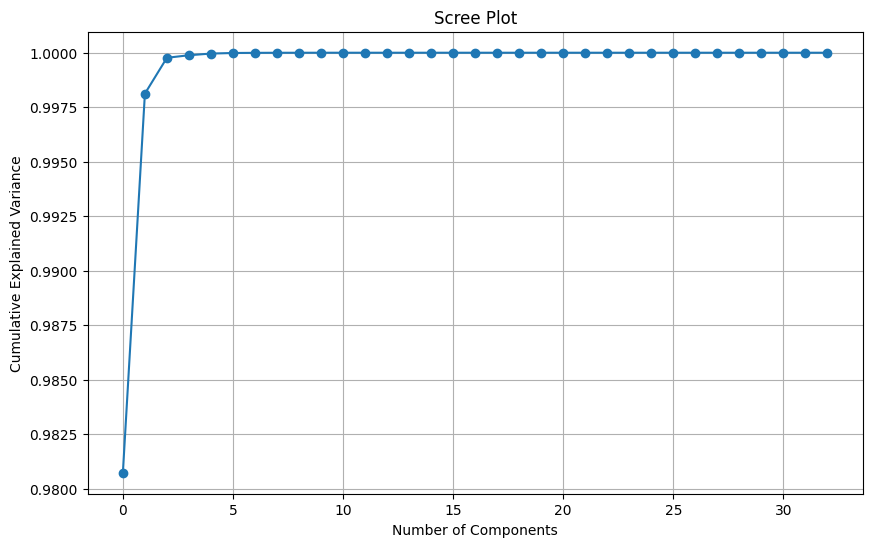

In [24]:

with mlflow.start_run(run_name="Experiment 5: PCA"):
    pca = PCA()
    pca.fit(X_train)
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
    plt.title('Scree Plot')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    scree_plot_path = "scree_plot.png"
    plt.savefig(scree_plot_path)
    mlflow.log_artifact(scree_plot_path)

    n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
    pca = PCA(n_components=n_components, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    pipeline = Pipeline([
        ('classifier', LogisticRegression(max_iter=5000, random_state=42))
    ])

    cv_scores = cross_val_score(pipeline, X_train_pca, y_train, cv=3, scoring='f1')
    mean_cv_f1 = np.mean(cv_scores)
    std_cv_f1 = np.std(cv_scores)
    mlflow.log_metric("f1_score_mean", mean_cv_f1)
    mlflow.log_metric("f1_score_std", std_cv_f1)

    pipeline.fit(X_train_pca, y_train)
    y_pred = pipeline.predict(X_test_pca)

    test_f1 = f1_score(y_test, y_pred)
    mlflow.log_metric("test_f1_score", test_f1)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    mlflow.log_metric("True_Positives", tp)
    mlflow.log_metric("True_Negatives", tn)
    mlflow.log_metric("False_Positives", fp)
    mlflow.log_metric("False_Negatives", fn)

    input_example = pd.DataFrame(X_test_pca[0:1])
    mlflow.sklearn.log_model(
        sk_model=pipeline,
        artifact_path="pca_model",
        input_example=input_example.to_dict(orient='records')[0],
        registered_model_name="PCA_LogisticRegression_Pipeline"
    )


**experiment 6**

In [25]:

mlflow.set_tracking_uri("https://dagshub.com/rajasaikatukuri/pythonproject.mlflow")
mlflow.set_experiment("Breast Cancer Multi-Classifier Experiment 6") 

<Experiment: artifact_location='mlflow-artifacts:/fd7ad81c215c4e3696df46d8dd67d3fa', creation_time=1734646168409, experiment_id='4', last_update_time=1734646168409, lifecycle_stage='active', name='Breast Cancer Multi-Classifier Experiment 6', tags={}>

In [26]:

with mlflow.start_run(run_name="Experiment 6: Gradient Boosting"):
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.model_selection import GridSearchCV

    gbc = GradientBoostingClassifier(random_state=42)

    param_grid = {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    }

    grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid, scoring='f1', cv=3, verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    cv_scores = cross_val_score(best_model, X_train, y_train, cv=3, scoring='f1')
    mean_cv_f1 = np.mean(cv_scores)
    std_cv_f1 = np.std(cv_scores)
    mlflow.log_metric("f1_score_mean", mean_cv_f1)
    mlflow.log_metric("f1_score_std", std_cv_f1)

    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    test_f1 = f1_score(y_test, y_pred)
    mlflow.log_metric("test_f1_score", test_f1)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    mlflow.log_metric("True_Positives", tp)
    mlflow.log_metric("True_Negatives", tn)
    mlflow.log_metric("False_Positives", fp)
    mlflow.log_metric("False_Negatives", fn)

    input_example = pd.DataFrame(X_test[0:1])
    mlflow.sklearn.log_model(
        sk_model=best_model,
        artifact_path="gradient_boosting_model",
        input_example=input_example.to_dict(orient='records')[0],
        registered_model_name="Gradient_Boosting_Classifier"
    )


Fitting 3 folds for each of 27 candidates, totalling 81 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'Gradient_Boosting_Classifier' already exists. Creating a new version of this model...
2024/12/20 21:01:10 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model

🏃 View run Experiment 6: Gradient Boosting at: https://dagshub.com/rajasaikatukuri/pythonproject.mlflow/#/experiments/4/runs/655f5a54a7c248a18918237e0d01dada
🧪 View experiment at: https://dagshub.com/rajasaikatukuri/pythonproject.mlflow/#/experiments/4


**Experiment 7**

In [28]:

mlflow.set_tracking_uri("https://dagshub.com/rajasaikatukuri/pythonproject.mlflow")
mlflow.set_experiment("Breast Cancer Multi-Classifier Experiment 7") 

<Experiment: artifact_location='mlflow-artifacts:/ada73e731a6649dead100f4cecdee9df', creation_time=1734668107119, experiment_id='8', last_update_time=1734668107119, lifecycle_stage='active', name='Breast Cancer Multi-Classifier Experiment 7', tags={}>

In [29]:

with mlflow.start_run(run_name="Experiment 7: Stacking Classifier"):
    from sklearn.ensemble import StackingClassifier
    base_models = [
        ('lr', LogisticRegression(max_iter=5000, random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('ridge', RidgeClassifier(random_state=42))
    ]
    meta_classifier = LogisticRegression(max_iter=5000, random_state=42)

    stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_classifier, cv=3)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('stacking', stacking_clf)
    ])

    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='f1')
    mean_cv_f1 = np.mean(cv_scores)
    std_cv_f1 = np.std(cv_scores)
    mlflow.log_metric("f1_score_mean", mean_cv_f1)
    mlflow.log_metric("f1_score_std", std_cv_f1)

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    test_f1 = f1_score(y_test, y_pred)
    mlflow.log_metric("test_f1_score", test_f1)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    mlflow.log_metric("True_Positives", tp)
    mlflow.log_metric("True_Negatives", tn)
    mlflow.log_metric("False_Positives", fp)
    mlflow.log_metric("False_Negatives", fn)

    input_example = pd.DataFrame(X_test[0:1])
    mlflow.sklearn.log_model(
        sk_model=pipeline,
        artifact_path="stacking_model",
        input_example=input_example.to_dict(orient='records')[0],
        registered_model_name="Stacking_Classifier_Pipeline"
    )

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'Stacking_Classifier_Pipeline' already exists. Creating a new version of this model...
2024/12/20 21:01:34 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model

🏃 View run Experiment 7: Stacking Classifier at: https://dagshub.com/rajasaikatukuri/pythonproject.mlflow/#/experiments/8/runs/72be06cbbb044d67adb2c9c4b4c6297b
🧪 View experiment at: https://dagshub.com/rajasaikatukuri/pythonproject.mlflow/#/experiments/8


**Creating bar plot to see which model done good in best f1 score**

Best Model Details:
Experiment       Breast Cancer Multi-Classifier Experiment 3
Run ID                      9d4fe374f79040e78ad40be355cd8796
Test F1 Score                                       0.987952
Name: 3, dtype: object


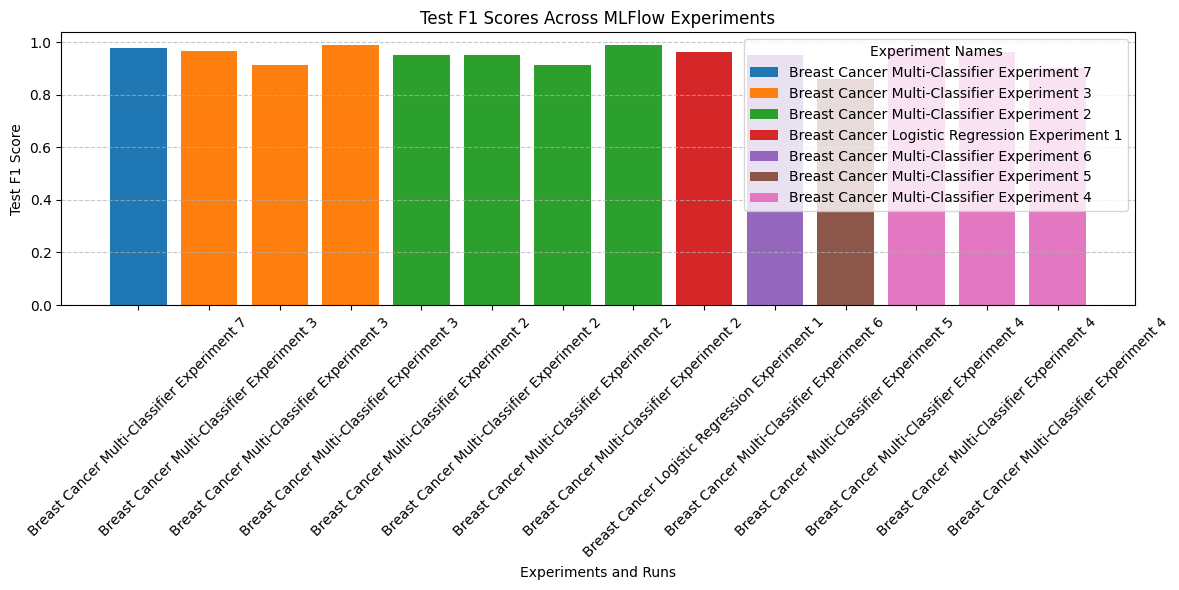

In [37]:
import mlflow
import pandas as pd
import matplotlib.pyplot as plt

mlflow.set_tracking_uri("https://dagshub.com/rajasaikatukuri/pythonproject.mlflow")
client = mlflow.tracking.MlflowClient()

experiments = client.search_experiments()

f1_scores = []
for experiment in experiments:
    experiment_name = experiment.name
    runs = client.search_runs(experiment.experiment_id)
    for run in runs:
        test_f1 = run.data.metrics.get("test_f1_score")
        if test_f1 is not None:
            f1_scores.append({
                "Experiment": experiment_name,
                "Run ID": run.info.run_id,
                "Test F1 Score": test_f1
            })

f1_df = pd.DataFrame(f1_scores)

best_model = f1_df.loc[f1_df['Test F1 Score'].idxmax()]

print("Best Model Details:")
print(best_model)

plt.figure(figsize=(12, 6))
for experiment_name in f1_df['Experiment'].unique():
    subset = f1_df[f1_df['Experiment'] == experiment_name]
    plt.bar(subset.index, subset['Test F1 Score'], label=experiment_name)

plt.title('Test F1 Scores Across MLFlow Experiments')
plt.ylabel('Test F1 Score')
plt.xlabel('Experiments and Runs')
plt.xticks(ticks=range(len(f1_df)), labels=f1_df['Experiment'], rotation=45)
plt.legend(title='Experiment Names')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [30]:
import joblib
import mlflow

model_uri = f"runs:/b1093160afee4e17bd104bb90fe85c72/model"
model = mlflow.pyfunc.load_model(model_uri)

joblib.dump(model, "/Users/rajasaikatukuri/Downloads/pythonproject/logistic_regression_best.joblib")
print("Model saved as 'logistic_regression_best.joblib'")


Model saved as 'logistic_regression_best.joblib'
